# Sandbox 1

In [ ]:
import requests

def get_game_release_date(app_id):
    """Get the release date of a game from the Steam Store API"""
    url = f"https://store.steampowered.com/api/appdetails?appids={app_id}"
    
    try:
        response = requests.get(url)
        data = response.json()
        
        if data[app_id]['success']:
            game_data = data[app_id]['data']
            
            # Get the game name
            name = game_data['name']
            
            # Get release date info
            release_date = game_data['release_date']
            date = release_date['date']
            is_coming_soon = release_date['coming_soon']
            
            return {
                'name': name,
                'release_date': date,
                'is_coming_soon': is_coming_soon
            }
        else:
            print(f"Failed to get data for app {app_id}")
            return None
    except Exception as e:
        print(f"Error getting game data: {e}")
        return None

# Example: The Witcher 3: Wild Hunt
app_id = "292030"
release_info = get_game_release_date(app_id)

if release_info:
    print(f"Game: {release_info['name']}")
    print(f"Release Date: {release_info['release_date']}")
    print(f"Coming Soon: {'Yes' if release_info['is_coming_soon'] else 'No'}")


Game: The Witcher 3: Wild Hunt
Release Date: May 18, 2015
Coming Soon: No


In [ ]:
import requests
import pandas as pd
import time

def get_all_steam_app_ids():
    """Get a list of all apps/games on Steam with their app IDs"""
    url = "https://api.steampowered.com/ISteamApps/GetAppList/v2/"
    
    try:
        response = requests.get(url)
        data = response.json()
        apps = data['applist']['apps']
        
        print(f"Retrieved {len(apps)} Steam apps")
        return apps  # This is a list of dictionaries with 'appid' and 'name' keys
    except Exception as e:
        print(f"Error getting app list: {e}")
        return []

# Get the full list of Steam apps
all_apps = get_all_steam_app_ids()

# Convert to a DataFrame for easier handling
df_apps = pd.DataFrame(all_apps)

# Filter out entries with no name or empty name
df_apps_filtered = df_apps[df_apps['name'].notna() & (df_apps['name'] != '')]

# Show the difference
print(f"Total apps: {len(df_apps)}")
print(f"Apps with names: {len(df_apps_filtered)}")
print(f"Removed {len(df_apps) - len(df_apps_filtered)} entries without names")

# Show the first few entries of the filtered dataset
print("\nFirst few apps with names:")
print(df_apps_filtered.head())

# Save to CSV
df_apps_filtered.to_csv('steam_apps_with_names.csv', index=False)
print(f"Saved {len(df_apps_filtered)} apps to steam_apps_with_names.csv")

Retrieved 237116 Steam apps
Total apps: 237116
Apps with names: 237046
Removed 70 entries without names

First few apps with names:
      appid                                               name
9    216938                      Pieterw test app76 ( 216938 )
10   660010                                              test2
11   660130                                              test3
38  2640430  Welcome to Albion! - Additional All-Ages Story...
39  2640440                       Otherworld Legends - Ourania
Saved 237046 apps to steam_apps_with_names.csv


In [9]:
def is_game(app_id):
    """Check if an app ID corresponds to a game (not DLC, software, etc.)"""
    url = f"https://store.steampowered.com/api/appdetails?appids={app_id}&filters=basic"
    
    try:
        response = requests.get(url)
        data = response.json()
        
        if app_id in data and data[app_id]['success']:
            app_type = data[app_id]['data'].get('type', '')
            return app_type.lower() == 'game'
        return False
    except:
        return False

# Warning: This would be very slow and might get your IP rate-limited
# Only use on a small subset of app IDs
sample_app_ids = df_apps['appid'].iloc[:10].astype(str).tolist()  # Just testing 10 apps
games_only = []

for app_id in sample_app_ids:
    if is_game(app_id):
        games_only.append(app_id)
    time.sleep(1)  # Be nice to the API

print(f"Found {len(games_only)} actual games out of {len(sample_app_ids)} tested apps")

Found 0 actual games out of 10 tested apps


In [13]:
import requests
import pandas as pd

def get_steamspy_data(app_id):
    """Get data for a specific game from SteamSpy API"""
    url = f"https://steamspy.com/api.php?request=appdetails&appid={app_id}"
    
    try:
        response = requests.get(url)
        return response.json()
    except Exception as e:
        print(f"Error getting data for app {app_id}: {e}")
        return None

def get_steamspy_top_games(limit=100):
    """Get data for top games by player count from SteamSpy API"""
    url = "https://steamspy.com/api.php?request=top100in2weeks"
    
    try:
        response = requests.get(url)
        data = response.json()
        return dict(list(data.items())[:limit])  # Limit to specified number
    except Exception as e:
        print(f"Error getting top games: {e}")
        return {}

# Example 1: Get data for a specific game (The Witcher 3)
app_id = "292030"  # The Witcher 3
game_data = get_steamspy_data(app_id)

if game_data:
    print(f"Game: {game_data.get('name', 'Unknown')}")
    print(f"Owners estimate: {game_data.get('owners', 'Unknown')}")
    print(f"Owners range: {game_data.get('owners_low', 'N/A')} - {game_data.get('owners_high', 'N/A')}")
    
    # Safely convert to integers and handle division
    avg_playtime = int(game_data.get('average_forever', 0))
    avg_hours = avg_playtime // 60  # Integer division with //
    
    median_playtime = int(game_data.get('median_forever', 0))
    median_hours = median_playtime // 60  # Integer division with //
    
    # Convert price from cents to dollars (ensure it's a number first)
    price_cents = float(game_data.get('price', 0))
    price_dollars = price_cents / 100.0  # Use floating point division
    
    print(f"Average playtime: {avg_hours} hours")
    print(f"Median playtime: {median_hours} hours")
    print(f"Price: ${price_dollars:.2f}")

# Example 2: Get top games by recent players
top_games = get_steamspy_top_games(10)  # Get top 10
if top_games:
    df_top = pd.DataFrame.from_dict(top_games, orient='index')

    if not df_top.empty:
        # Make sure columns are numeric before performing division
        if 'average_2weeks' in df_top.columns:
            df_top['average_2weeks'] = pd.to_numeric(df_top['average_2weeks'], errors='coerce')
            df_top['avg_playtime_2weeks_hours'] = df_top['average_2weeks'] / 60.0
        
        if 'price' in df_top.columns:
            df_top['price'] = pd.to_numeric(df_top['price'], errors='coerce')
            df_top['price_usd'] = df_top['price'] / 100.0
        
        print("\nTop 10 games by recent players:")
        print(df_top[['name', 'owners', 'avg_playtime_2weeks_hours', 'price_usd']].sort_values('owners', ascending=False))

Game: The Witcher 3: Wild Hunt
Owners estimate: 10,000,000 .. 20,000,000
Owners range: N/A - N/A
Average playtime: 0 hours
Median playtime: 0 hours
Price: $39.99

Top 10 games by recent players:
                                     name                      owners  \
578080                PUBG: BATTLEGROUNDS   50,000,000 .. 100,000,000   
1623730                          Palworld   50,000,000 .. 100,000,000   
1172470                      Apex Legends   50,000,000 .. 100,000,000   
1063730               New World: Aeternum   50,000,000 .. 100,000,000   
2358720                Black Myth: Wukong   50,000,000 .. 100,000,000   
1938090   Call of Duty: Modern Warfare II   50,000,000 .. 100,000,000   
271590          Grand Theft Auto V Legacy   50,000,000 .. 100,000,000   
550                         Left 4 Dead 2   50,000,000 .. 100,000,000   
570                                Dota 2  200,000,000 .. 500,000,000   
730      Counter-Strike: Global Offensive  100,000,000 .. 200,000,000   

 

In [14]:
import requests

def is_indie_game(app_id):
    """Check if a game has the 'Indie' tag on Steam"""
    url = f"https://store.steampowered.com/api/appdetails?appids={app_id}&filters=categories,genres,developers,publishers"
    
    try:
        response = requests.get(url)
        data = response.json()
        
        if app_id in data and data[app_id]['success']:
            game_data = data[app_id]['data']
            
            # Check if "Indie" is in the genres
            if 'genres' in game_data:
                for genre in game_data['genres']:
                    if genre['description'].lower() == 'indie':
                        return True
            
            # Check for tags (note: this is not always in the basic appdetails response)
            # You might need to use the Steam store page and parse HTML for more reliable tag data
            
            # Check if developer and publisher are the same (common for indie games)
            if 'developers' in game_data and 'publishers' in game_data:
                developers = set(game_data['developers'])
                publishers = set(game_data['publishers'])
                if developers == publishers and len(developers) == 1:
                    # Same entity is both developer and publisher - a hint it might be indie
                    return "Likely (same dev/pub)"
            
            return False
        else:
            print(f"Failed to get data for app {app_id}")
            return None
    except Exception as e:
        print(f"Error checking indie status: {e}")
        return None

# Example: Check a few games
indie_game_id = "1590940"  # Stardew Valley
aaa_game_id = "1091500"    # Cyberpunk 2077

print(f"Is Stardew Valley an indie game? {is_indie_game(indie_game_id)}")
print(f"Is Cyberpunk 2077 an indie game? {is_indie_game(aaa_game_id)}")

Is Stardew Valley an indie game? True
Is Cyberpunk 2077 an indie game? Likely (same dev/pub)


In [16]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

def create_game_companies_database_from_wikipedia():
    """Create a database of game companies by scraping Wikipedia"""
    
    # URL for Wikipedia's list of video game developers
    wiki_url = "https://en.wikipedia.org/wiki/List_of_video_game_developers"
    
    try:
        # Get the page content
        response = requests.get(wiki_url)
        response.raise_for_status()  # Raise exception for bad status codes
        
        # Parse the HTML
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find all tables on the page
        tables = soup.find_all('table', {'class': 'wikitable'})
        
        all_companies = []
        
        # Process each table
        for table in tables:
            # Get all rows except the header
            rows = table.find_all('tr')[1:]
            
            for row in rows:
                # Get all cells in the row
                cells = row.find_all(['td', 'th'])
                
                # Skip rows that don't have enough cells
                if len(cells) < 2:
                    continue
                
                # The first cell usually contains the company name
                company_cell = cells[0]
                
                # Try to get the name from link if available, otherwise use text
                company_link = company_cell.find('a')
                if company_link and company_link.get('title'):
                    company_name = company_link.get('title')
                else:
                    company_name = company_cell.text.strip()
                
                # Skip empty names
                if not company_name:
                    continue
                
                # Get country information if available (usually in the second cell)
                country = cells[1].text.strip() if len(cells) > 1 else ""
                
                # Get additional info if available
                additional_info = {}
                for i, cell in enumerate(cells[2:], 2):
                    cell_text = cell.text.strip()
                    if cell_text:
                        additional_info[f"col_{i}"] = cell_text
                
                # Add to our list
                company_info = {
                    'name': company_name,
                    'country': country,
                    **additional_info
                }
                
                all_companies.append(company_info)
        
        # Convert to DataFrame
        df_companies = pd.DataFrame(all_companies)
        
        # Clean up the data
        if 'name' in df_companies.columns:
            # Remove footnote references like [1], [2], etc.
            df_companies['name'] = df_companies['name'].str.replace(r'\[\d+\]', '', regex=True)
            
            # Remove any leading/trailing whitespace
            df_companies['name'] = df_companies['name'].str.strip()
        
        # Remove duplicates
        df_companies = df_companies.drop_duplicates(subset=['name'])
        
        # Save to CSV
        df_companies.to_csv('game_companies_from_wikipedia.csv', index=False)
        
        print(f"Successfully scraped {len(df_companies)} game companies from Wikipedia")
        return df_companies
        
    except Exception as e:
        print(f"Error scraping Wikipedia: {e}")
        return pd.DataFrame()

# Execute the function
game_companies_df = create_game_companies_database_from_wikipedia()

# Display the first few rows to see what we got
if not game_companies_df.empty:
    print("\nFirst 10 companies:")
    print(game_companies_df.head(10))

Successfully scraped 733 game companies from Wikipedia

First 10 companies:
               name     country           col_3 col_4  \
0          0verflow       Tokyo           Japan  1997   
1    11 bit studios      Warsaw          Poland  2010   
2        1C Company      Moscow          Russia  1991   
3       1-Up Studio       Tokyo           Japan  2000   
4          2K Czech        Brno  Czech Republic  1997   
5      2K (company)      Novato   United States  2005   
6    343 Industries     Redmond   United States  2009   
7        38 Studios  Providence   United States  2006   
8         3D Realms     Garland   United States  1987   
9  42 Entertainment    Pasadena   United States  1993   

                                  col_5  \
0      School DaysSummer DaysCross Days   
1             This War of MineFrostpunk   
2  King's Bounty: Warriors of the North   
3                              Mother 3   
4                         MafiaMafia II   
5                                   Na

In [5]:
from cs670 import lsm_american_option
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats

# Parameters
S0 = 100      # Initial stock price
K = 100       # Strike price
r = 0.05      # Risk-free rate
T = 1.0       # Time to maturity (years)
sigma = 0.2   # Volatility
n_steps = 50  # Number of time steps
n_paths = 10000  # Number of simulation paths

# Price American options
call_price = lsm_american_option(S0, K, r, T, sigma, n_steps, n_paths, option_type='call')
put_price = lsm_american_option(S0, K, r, T, sigma, n_steps, n_paths, option_type='put')

print(f"American Call Option Price: {call_price:.4f}")
print(f"American Put Option Price: {put_price:.4f}")

# Compare with European option prices (Black-Scholes)
def black_scholes(S0, K, r, T, sigma, option_type='call'):
    d1 = (np.log(S0/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type.lower() == 'call':
        price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # put
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
        
    return price

euro_call = black_scholes(S0, K, r, T, sigma, 'call')
euro_put = black_scholes(S0, K, r, T, sigma, 'put')

print(f"European Call Option Price: {euro_call:.4f}")
print(f"European Put Option Price: {euro_put:.4f}")

print(f"Early Exercise Premium (Call): {call_price - euro_call:.4f}")
print(f"Early Exercise Premium (Put): {put_price - euro_put:.4f}")

American Call Option Price: 10.2165
American Put Option Price: 6.1066
European Call Option Price: 10.4506
European Put Option Price: 5.5735
Early Exercise Premium (Call): -0.2341
Early Exercise Premium (Put): 0.5331


<Figure size 1200x1000 with 0 Axes>

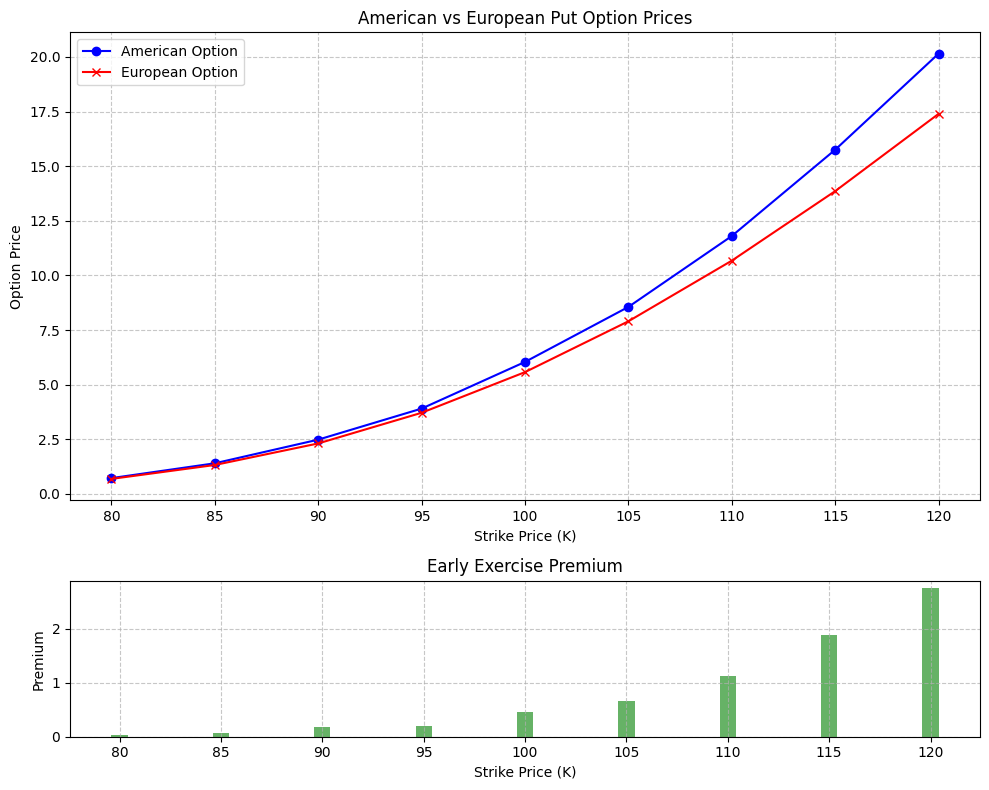

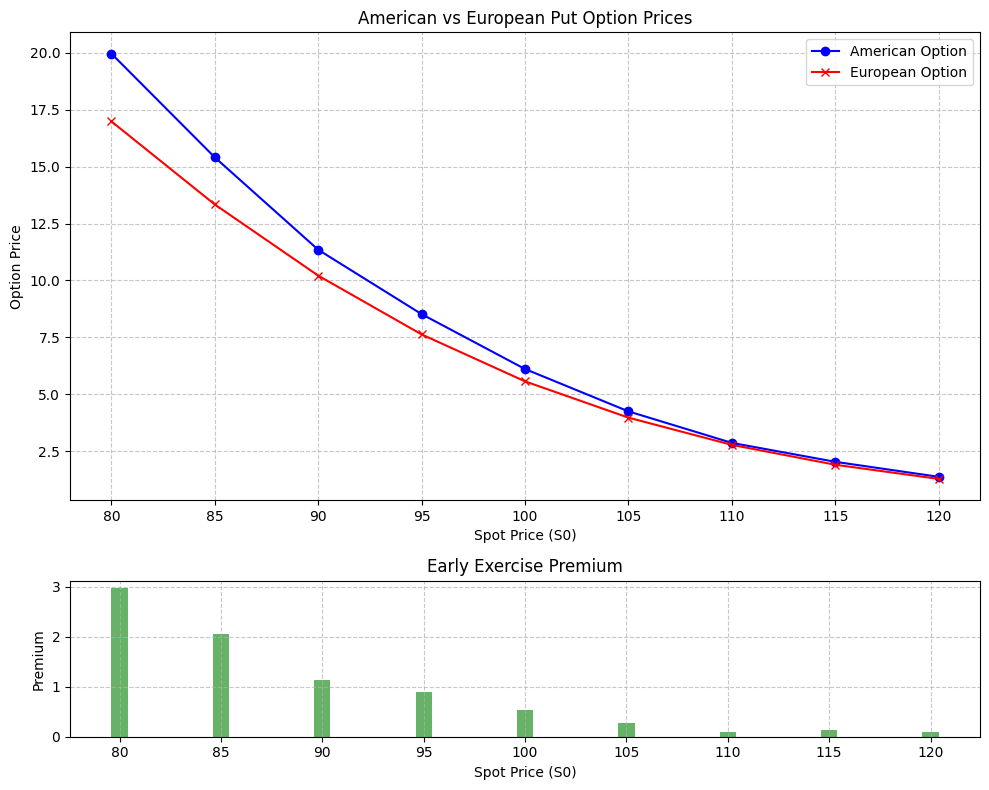

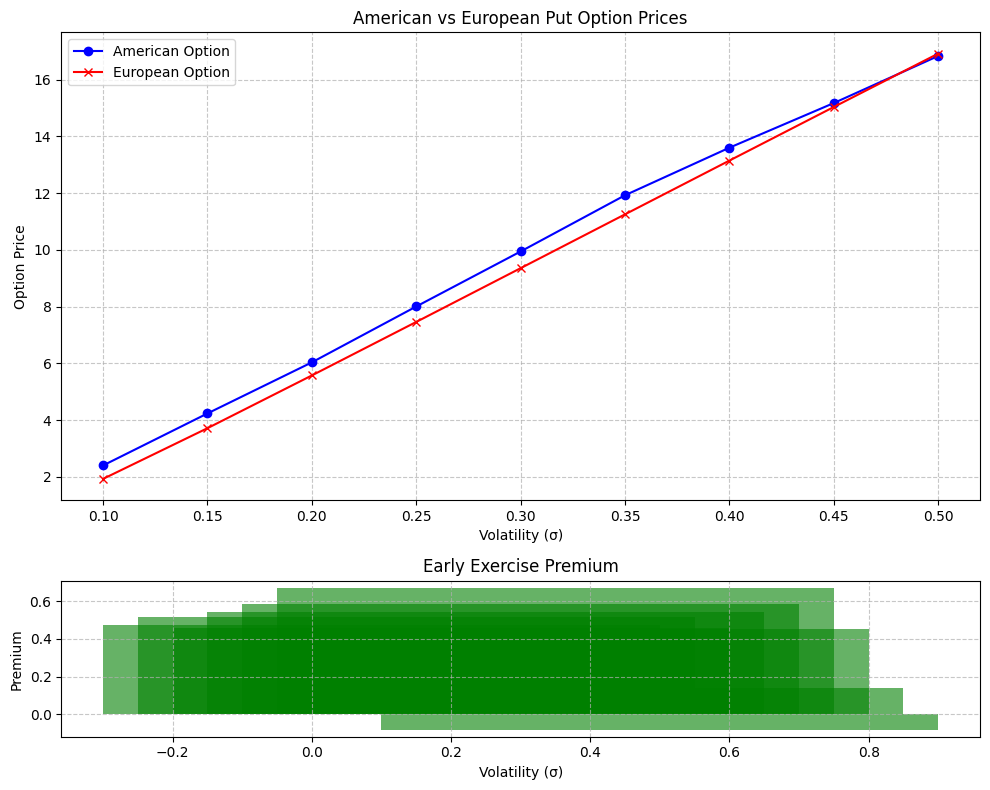

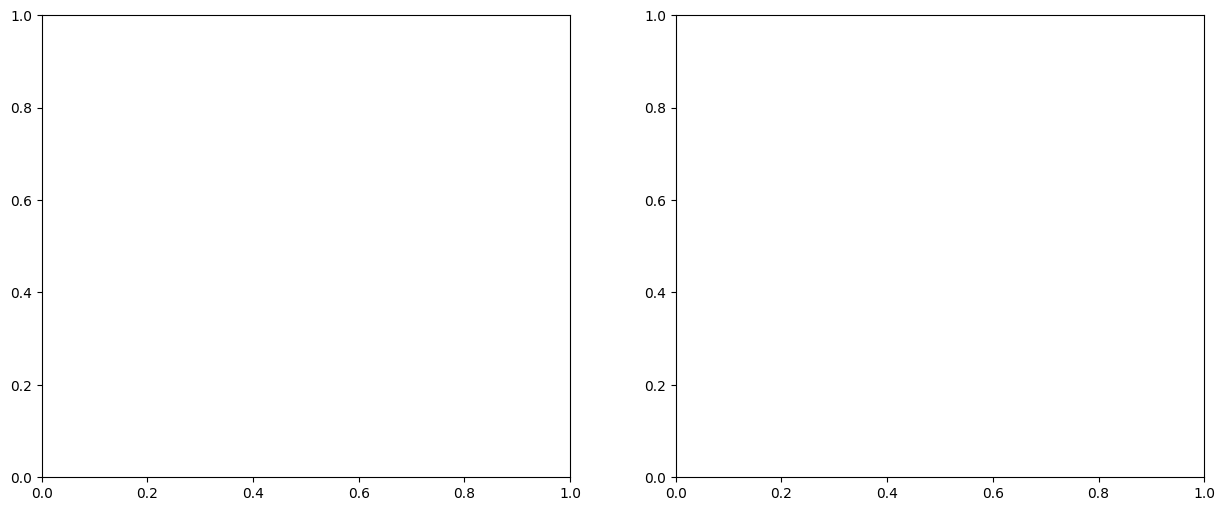

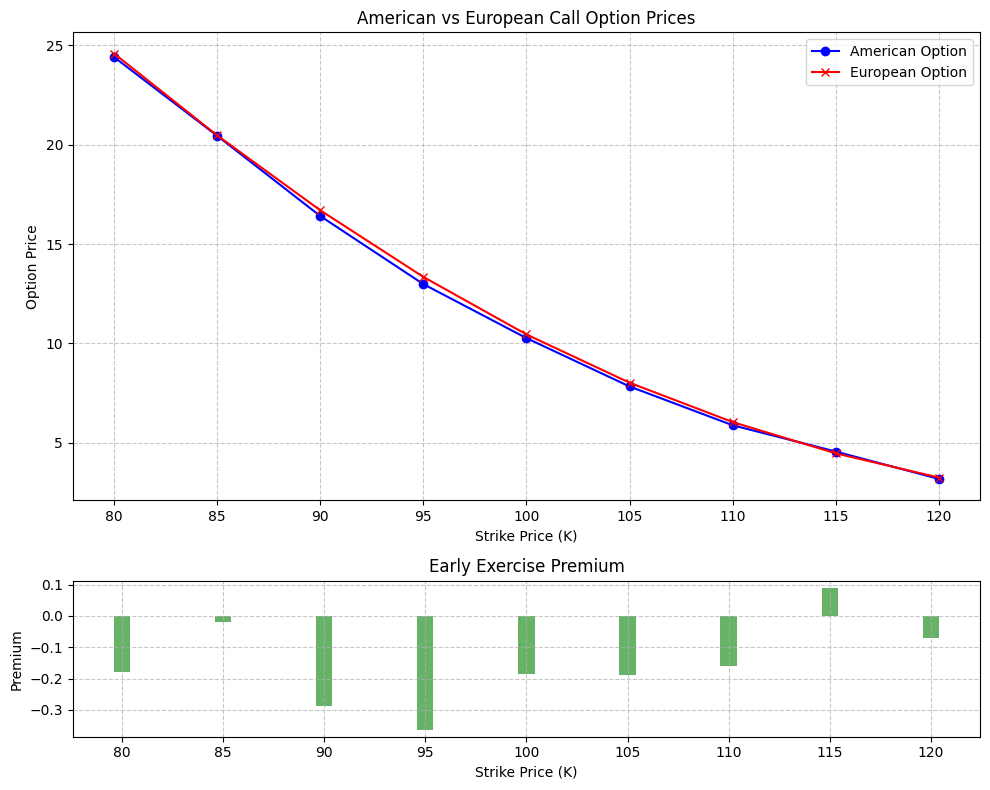

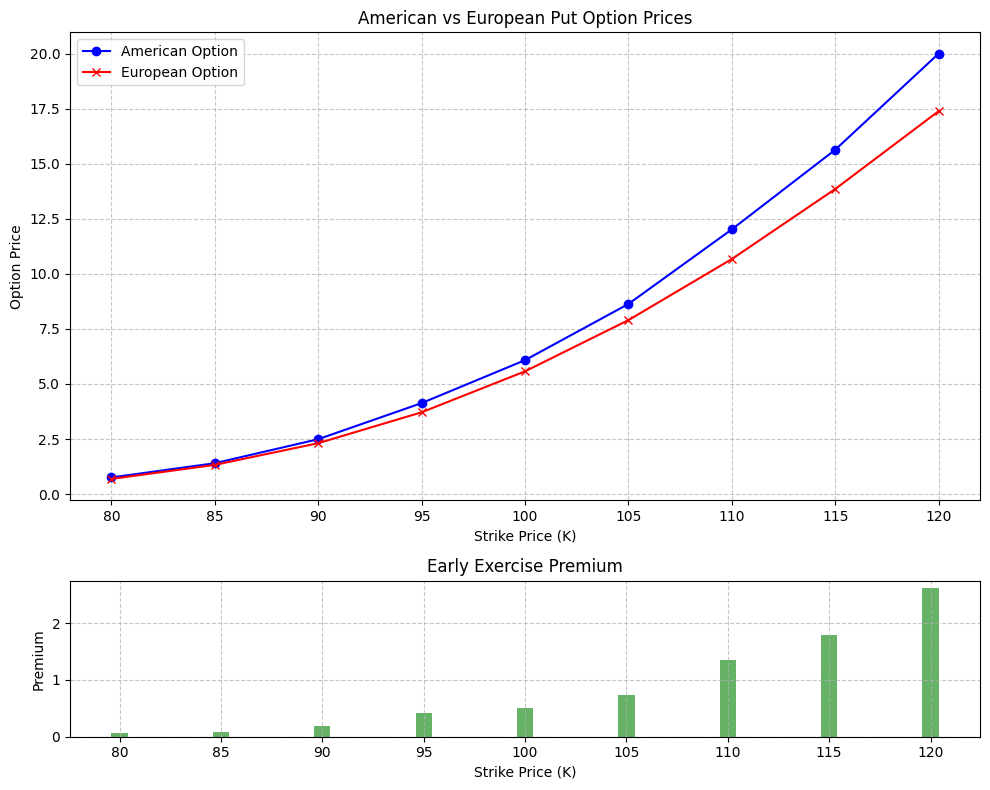

In [2]:
from cs670 import plot_lsm_american_option
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
# Plot American put option prices for different strikes
plt.figure(figsize=(12, 10))

# 1. Vary strike prices
plot_lsm_american_option(option_type='put', parameter='strike')
plt.savefig('american_put_vs_strike.png')

# 2. Vary spot prices
plot_lsm_american_option(option_type='put', parameter='spot')
plt.savefig('american_put_vs_spot.png')

# 3. Vary volatility
plot_lsm_american_option(option_type='put', parameter='volatility')
plt.savefig('american_put_vs_volatility.png')

# 4. Plot both call and put for comparison
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Arguments for subplot calls
call_fig = plot_lsm_american_option(option_type='call', parameter='strike')
put_fig = plot_lsm_american_option(option_type='put', parameter='strike')

plt.tight_layout()
plt.savefig('american_options_comparison.png')

plt.show()

# Sandbox Steam with Unemployment

In [ ]:
import pandas